In [29]:
from fastai.vision.all import *
from natsort import natsorted
import cv2
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import albumentations as A

In [20]:
def yolo2xyxy(bboxes,H,W):
    ''' bboxes is an array of shape (N,4) for x_c, y_c, w,h in yolo format'''
    xmin = (bboxes[:,0] - bboxes[:,2]/2)*W
    ymin = (bboxes[:,1] - bboxes[:,3]/2)*H
    xmax = (bboxes[:,0] + bboxes[:,2]/2)*W
    ymax = (bboxes[:,1] + bboxes[:,3]/2)*H

    return np.stack([xmin,ymin,xmax,ymax], axis=1)

def crop_image(img, coordinates):
    cropped_img = img[int(coordinates[1]):int(coordinates[3]), int(coordinates[0]):int(coordinates[2])]
    return cropped_img


def make_classes_folders(src_dir, to_run = False):
    dest_dir = f"{dataset_dir.parent}/classes"
    print('Extracting symbol crops to: ', dest_dir)
    if to_run:
        os.makedirs(dest_dir, exist_ok=True)
        im_pths =  natsorted(get_files(src_dir, extensions='.jpg'))
        print('Total Images: ', len(im_pths))

        counter = 0
        im_counter = 0
        for im_pth in im_pths:
            im = cv2.imread(str(im_pth))
            H,W = im.shape[:2]
            im_name = im_pth.name[:-4]
            txt_name = im_name+'.txt'
            txt_pth = os.path.join(im_pth.parent, txt_name)
            with open(txt_pth, 'r') as f:
                lines = f.readlines()
                f.close()

            ls = [list(map(float,l.split())) for l in lines] # each line as a list of floats
            arr = np.stack(ls) # convert to array for easy indexing
            class_labels = arr[:,0].tolist()
            bboxes = arr[:,1:]
            xyxy_boxes = yolo2xyxy(bboxes,H,W)
            for class_id, box in zip(class_labels, xyxy_boxes):
                class_id = int(class_id)
                os.makedirs(f"{dest_dir}/{class_id}", exist_ok=True)
                cropped_im = crop_image(im, box)
                cv2.imwrite(f'{dest_dir}/{class_id}/{im_name}_{counter}.jpg',cropped_im)
                counter+=1

            im_counter+=1
            if im_counter%5==0:
                print(f'Processed {im_counter} drawings and saved {counter} symbols')
                
        print('************** DONE *****************')

#### 1. Set the path to folder containing Dataset (full PID Images + Yolo Annotations)

In [2]:
root_dir = Path('../data/sample_dataset/') # root directory
original_dir = 'original' # directory in root directory containing PID Images and CAware  YOLO annotations
dataset_dir = Path(f"{root_dir}/{original_dir}")

In [19]:
make_classes_folders(dataset_dir, to_run=False)

Extracting symbol crops to:  ..\data\sample_dataset/classes
Total Images:  10
Processed 5 drawings and saved 512 symbols
Processed 10 drawings and saved 1034 symbols
************** DONE *****************


#### Load one-shot image per symbol class

In [6]:
def get_support_set(classes_dir, m=1):
    """Get m=1 symbol per class."""
    support_symbols, support_targets = get_m_symbols(classes_dir, m, to_run=True)
    support_set_dict = get_support_set_dict(support_symbols, support_targets)
    return support_symbols, support_targets, support_set_dict


def get_m_symbols(classes_dir, m=1, to_run = False):
    
    print(f"Getting {m} symbols randomly per class")
    subfolder_pths, subfolder_names, fnames = zip(*[(dirpath, dirnames, filenames) for dirpath, dirnames, filenames in os.walk(classes_dir)])
    subfolder_pths = subfolder_pths[1:]; subfolder_names = subfolder_names[0]; fnames = fnames[1:]
    symbols = []
    targets = []
    for sub_pth, sub_name, sub_files in zip(subfolder_pths,subfolder_names,fnames):
        rand_m_symbols = random.sample(sub_files, m)
        rand_m_symbols_fpth = [os.path.join(sub_pth, o) for o in rand_m_symbols]
        symbols.append(rand_m_symbols_fpth)
        targets.append([int(sub_name)]*len(rand_m_symbols))

    symbols = [element for ls in symbols for element in ls]# flattent the list
    targets = [element for ls in targets for element in ls]# flattent the list
    print(f"Selected {len(symbols)} symbols and len of targets is also {len(targets)}")

    targ_names = list(Counter(targets).keys())
    targ_counts = list(Counter(targets).values())    
    print('******** DONE *************')
    return symbols, targets

def get_support_set_dict(support_symbols, support_targets):
    support_set_dict = {}
    for pth,label in zip(support_symbols, support_targets):
        if label not in support_set_dict:
            support_set_dict[label] = []
        support_set_dict[label].append(pth)
    return support_set_dict

In [22]:

def get_support_set(classes_dir, m=1):
    """Get m=1 symbol per class."""
    support_symbols, support_targets = get_m_symbols(classes_dir, m, to_run=True)
    support_set_dict = get_support_set_dict(support_symbols, support_targets)
    return support_symbols, support_targets, support_set_dict

In [23]:
# Usage
classes_dir = f"{dataset_dir.parent}/classes"

# Step 1: Get support set
support_symbols, support_targets, support_set_dict = get_support_set(classes_dir, m=1)

Getting 1 symbols randomly per class
Selected 32 symbols and len of targets is also 32
******** DONE *************


In [13]:
def visualize_one_shot_selection(support_symbols, support_targets):
    """Display the one-shot selection of symbols."""
    ims = [cv2.imread(str(im_pth)) for im_pth in support_symbols]
    show_images(ims, titles=support_targets, nrows=3)

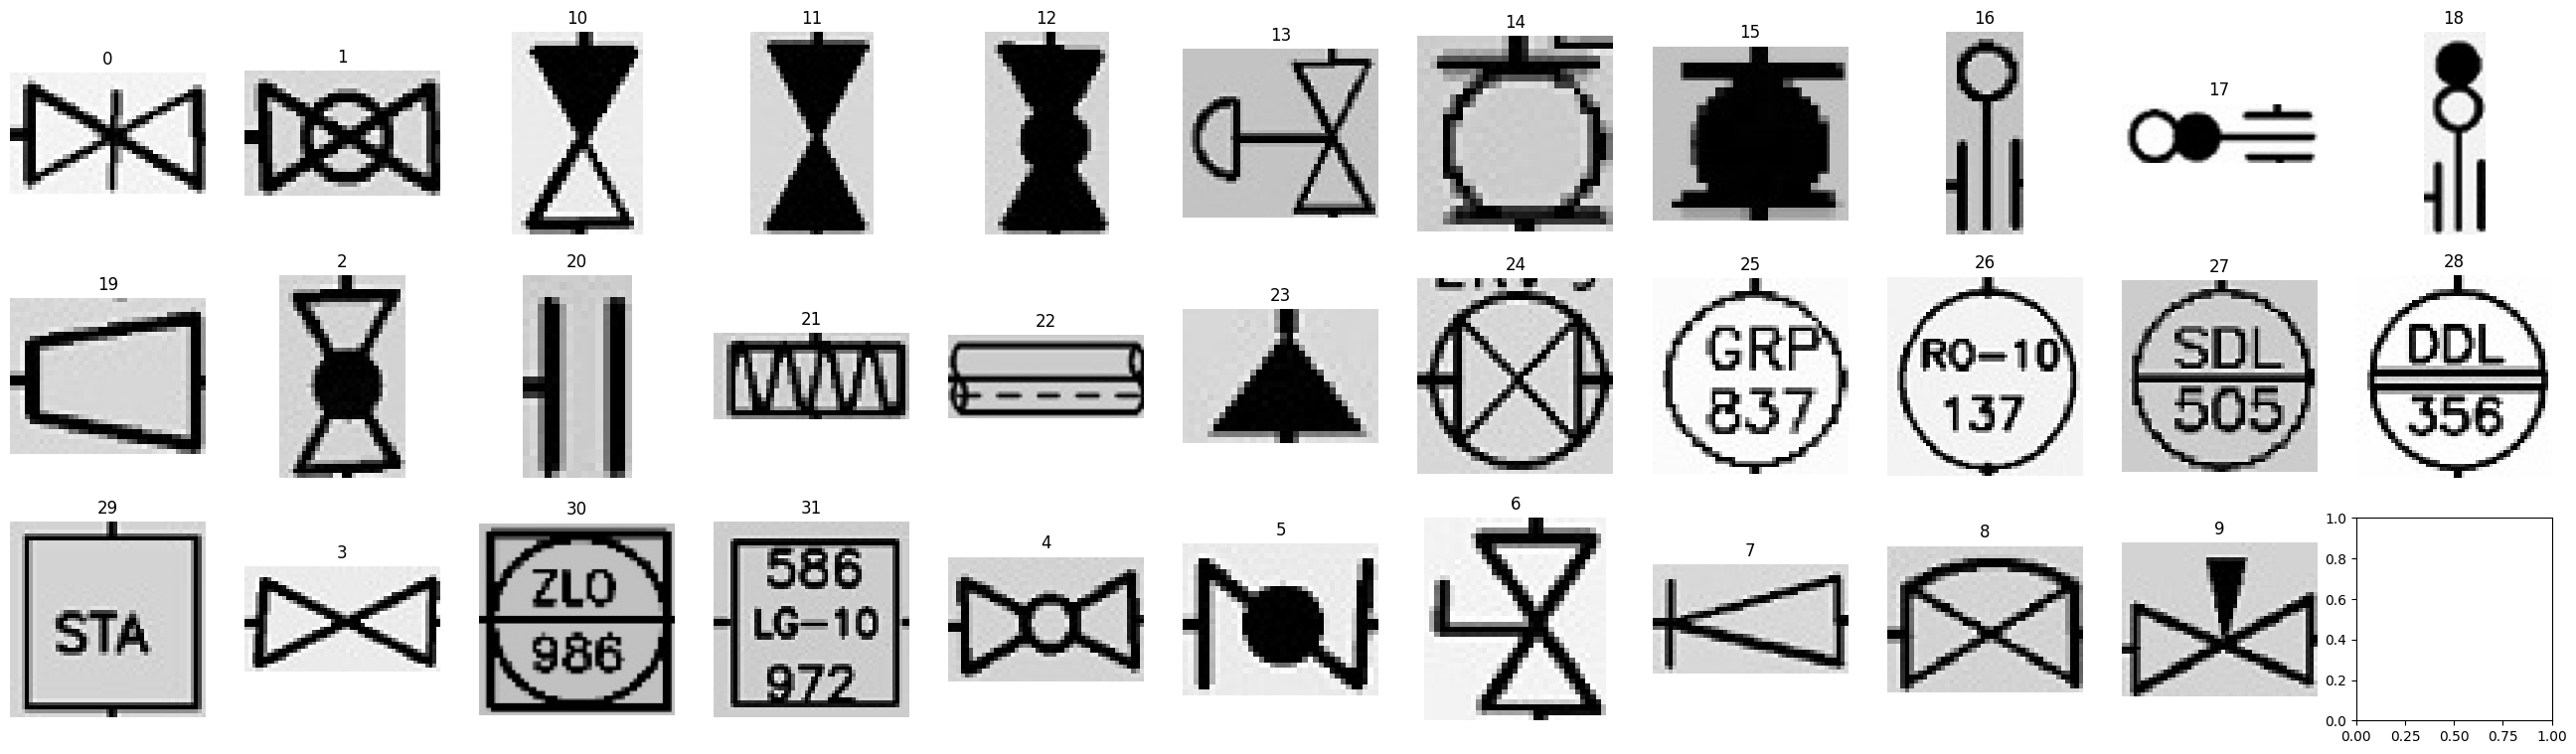

In [14]:
# Step 2: Visualize one-shot selection
visualize_one_shot_selection(support_symbols, support_targets)

In [15]:
def visualize_augmentations(augmentations, support_symbols, support_targets, num_aug=20):
    """Visualize augmentations on a sample class."""
    im = cv2.imread(support_symbols[random.randint(0, len(support_targets) - 1)])
    plt.figure(figsize=(1, 1))
    plt.imshow(im)
    plt.axis('off')
    plt.show()

    transformed_ims = [augmentations(image=im)['image'] for _ in range(num_aug)]
    show_images(transformed_ims, nrows=2)

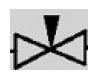

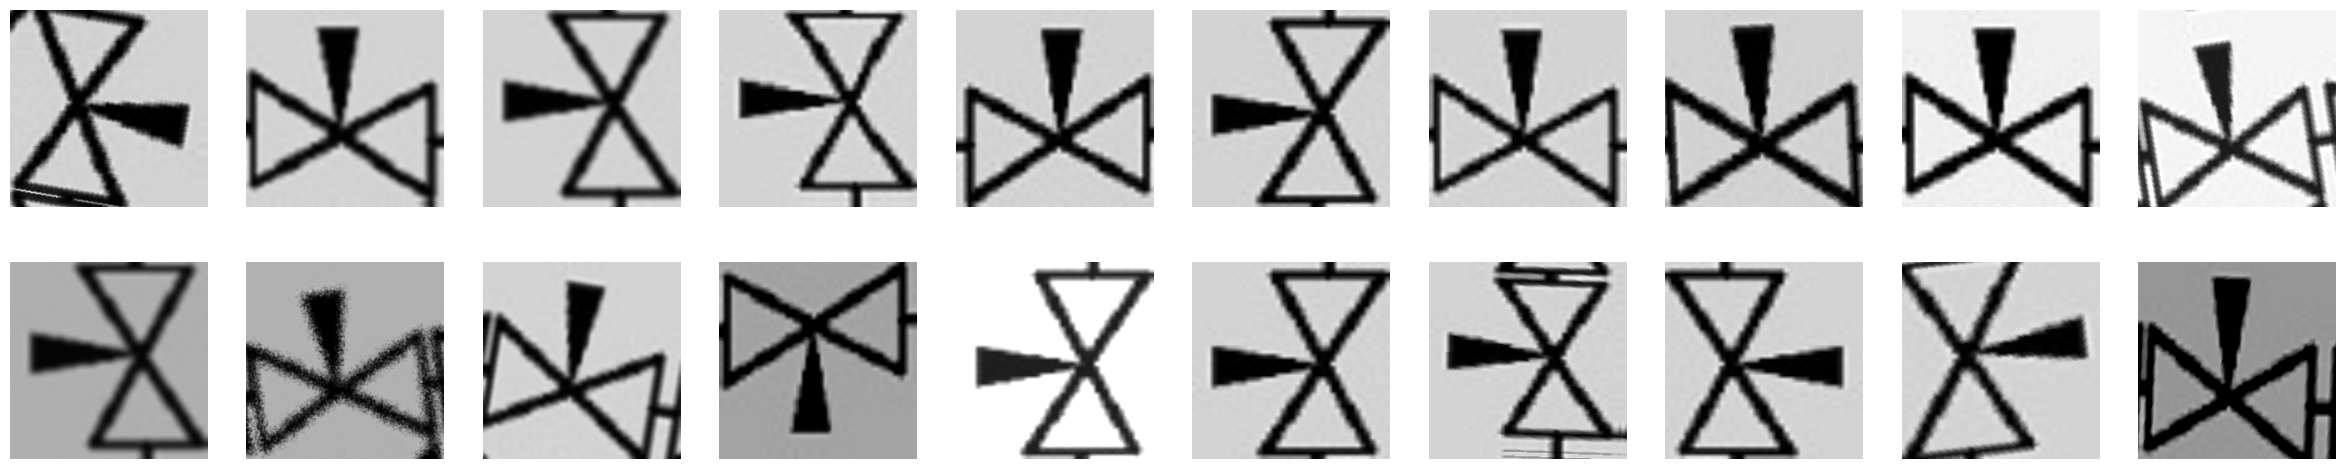

In [21]:
# Step 3: Visualize augmentations
augs = A.Compose([
    A.Resize(height = 224, width = 224),
    A.D4(p=1),
    A.GridDistortion(distort_limit=(-0.1, 0.1), p=0.5),
    A.ShiftScaleRotate(rotate_limit = (-10,10),interpolation = 0, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.AdvancedBlur(p=0.2),
    A.Defocus(radius=(3, 5), alias_blur=(0.05, 0.15), p=0.15),
    #A.Equalize(p=1), ########## Binarise #####
    A.GaussNoise(p=0.15),
    A.GaussianBlur(p=0.2),
    A.GlassBlur(p=0.1), #### simulate scanned dwgs
    A.Morphological(scale=(2, 3), operation='dilation', p=0.2),
    A.Morphological(scale=(2, 3), operation='erosion', p=0.2)
])

visualize_augmentations(augs, support_symbols, support_targets)

In [30]:
def augment_data(support_set_dict, num_per_class, augmentations):
    """ works for 1 shot or 2 shot or 5 shot support set"""
    augmented_images = []
    augmented_labels = []

    for label in list(support_set_dict.keys()):
        for i in range(num_per_class):
            rand_pth = random.choice(support_set_dict[label])
            im = cv2.imread(rand_pth)
            transformed_im = augmentations(image = im)
            augmented_images.append(transformed_im['image'])
            augmented_labels.append(label)
    return augmented_images, augmented_labels

class One_shot_Dataset_st_list(Dataset):
    ''' PID dataset from symbols array list & targets list'''
    def __init__(self, symbols, targets, transform=None):
        self.symbols = symbols
        self.targets = targets 
        self.transform = transform

    def __len__(self):
        return len(self.symbols)

    def __getitem__(self, idx):
        symbol_image = Image.fromarray(self.symbols[idx])
        if self.transform:
            symbol_image = self.transform(symbol_image)
        label = self.targets[idx]
        return symbol_image, label 

def augment_and_prepare_datasets(support_set_dict, augmentations, num_per_class=10, train_percent=0.75, batch_size=16):
    """Augment data and load into dataloaders."""
    num_per_class_train = int(train_percent * num_per_class)
    num_per_class_val = num_per_class - num_per_class_train

    train_syms, train_targs = augment_data(support_set_dict, num_per_class_train, augmentations)
    print(f'Total Train images and labels generated are: {len(train_syms)}, {len(train_targs)}')

    val_syms, val_targs = augment_data(support_set_dict, num_per_class_val, augmentations)
    print(f'Total Val images and labels generated are: {len(val_syms)}, {len(val_targs)}')

    to_tensor = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
    ])

    train_dataset = One_shot_Dataset_st_list(symbols=train_syms, targets=train_targs, transform=to_tensor)
    val_dataset = One_shot_Dataset_st_list(symbols=val_syms, targets=val_targs, transform=to_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def show_sample_batch(loader):
    """Display a sample batch of images and targets from a DataLoader."""
    for ims, targs in loader:
        print(ims.shape, targs.shape)
        show_image_batch((ims, targs), items=8, cols=8, figsize=(8, 1))
        break



Total Train images and labels generated are: 224, 224


Total Val images and labels generated are: 96, 96
torch.Size([16, 3, 224, 224]) torch.Size([16])


torch.Size([16, 3, 224, 224]) torch.Size([16])


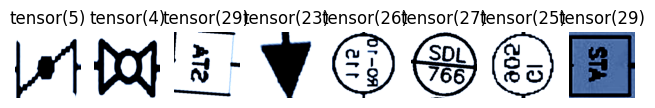

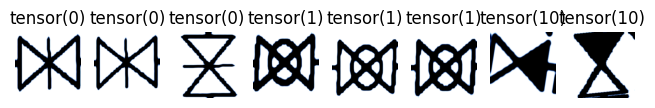

In [31]:
# Step 4: Augment and prepare datasets
train_loader, val_loader = augment_and_prepare_datasets(support_set_dict, augmentations=augs)

# Step 5: Show sample batches
show_sample_batch(train_loader)
show_sample_batch(val_loader)

#### Train the model for classification & save weights

In [33]:
def initialize_model(num_classes):
    """Initialize the ResNet model for training."""
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=None, dest_dir='./', version='1.0'):
    """Train the model and evaluate it on validation and test sets."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_corrects = 0.0, 0
        start = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)

        # Validation phase
        val_loss, val_corrects = 0.0, 0
        model.eval()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_corrects / len(val_loader.dataset)
        end = time.time()

        print(f"Epoch {epoch+1}/{num_epochs}  Time: {end-start} sec")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"{dest_dir}/best_model_{num_epochs}_{epoch}_v{version}.pth")

    return model

In [ ]:
# Step 6: Model training
num_classes = len(support_set_dict.keys())
print('Number of classes:', num_classes)

model = initialize_model(num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

model = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, dest_dir=dest_dir, version=version)

#### Perform Label Transfer on the symbols detected at the end of Stage-1 (Class-Agnosic Detection)

In [6]:
# Create an empty .gitkeep file
import os
gitkeep_path = os.path.join(os.getcwd(), '.gitkeep')
with open(gitkeep_path, 'w') as f:
    pass

In [5]:
os.getcwd()

'C:\\Users\\mgupta70\\ASU Dropbox\\Mohit Gupta\\ASU\\PhD\\Courses\\Github_projects\\PID_Symbol_Detection\\notebooks'